# Phase 6: Deep Learning & Evaluation

**Dataset**: AG News (4 classes)  
**Goal**: Implement a Simple Feedforward Neural Network (FFNN) as a benchmark against the classical ML models (SGD, Logistic Regression).

## 0 · Imports

In [1]:
import numpy as np
import scipy.sparse as sp
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

# ── Paths ────────────────────────────────────────────────────────────────────
ROOT        = os.path.abspath(os.path.join(os.getcwd(), '..'))
PROCESSED   = os.path.join(ROOT, 'data', 'processed')
MODELS_DIR  = os.path.join(ROOT, 'models')
os.makedirs(MODELS_DIR, exist_ok=True)

CLASS_NAMES = ['World', 'Sports', 'Business', 'Sci/Tech']
print('ROOT:', ROOT)
print('TF Version:', tf.__version__)

ROOT: c:\Users\My Device\Desktop\News-Category-Classification-E
TF Version: 2.20.0


## 1 · Load Data

We use the same TF-IDF matrices from Phase 4.

In [2]:
X_train_sparse = sp.load_npz(os.path.join(PROCESSED, 'X_train.npz'))
X_test_sparse  = sp.load_npz(os.path.join(PROCESSED, 'X_test.npz'))
y_train = np.load(os.path.join(PROCESSED, 'y_train.npy'))
y_test  = np.load(os.path.join(PROCESSED, 'y_test.npy'))

if y_train.min() == 1:
    y_train = y_train - 1
    y_test  = y_test - 1

print(f'X_train range: {X_train_sparse.shape} | X_test range: {X_test_sparse.shape}')

X_train range: (120000, 50000) | X_test range: (7600, 50000)


## 2 · Data Generator

Keras `Dense` layers require dense inputs. Since our 50k-feature matrix is too large to fit in memory as a dense array, we use a generator to yield dense batches from the sparse matrix.

In [3]:
def sparse_batch_generator(X, y, batch_size=64, shuffle=True):
    """Yields dense batches from a sparse matrix."""
    samples = X.shape[0]
    indices = np.arange(samples)
    
    while True:
        if shuffle:
            np.random.shuffle(indices)
        
        for start in range(0, samples, batch_size):
            end = min(start + batch_size, samples)
            batch_idx = indices[start:end]
            
            # Slice sparse matrix and convert to dense
            X_batch = X[batch_idx].toarray()
            y_batch = y[batch_idx]
            
            yield X_batch, y_batch

## 3 · Model Architecture

A simple Feedforward Neural Network with:
- 1 hidden layer (128 units)
- Dropout for regularisation
- Softmax output for 4 classes

In [4]:
dim = X_train_sparse.shape[1]

model = Sequential([
    Input(shape=(dim,)),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │     6,400,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,408,644 (24.45 MB)

 Trainable params: 6,408,644 (24.45 MB)

 Non-trainable params: 0 (0.00 B)

## 4 · Training

In [5]:
BATCH_SIZE = 128
EPOCHS = 20

train_gen = sparse_batch_generator(X_train_sparse, y_train, batch_size=BATCH_SIZE)
val_steps = X_test_sparse.shape[0] // BATCH_SIZE
train_steps = X_train_sparse.shape[0] // BATCH_SIZE

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    epochs=EPOCHS,
    validation_data=sparse_batch_generator(X_test_sparse, y_test, batch_size=BATCH_SIZE),
    validation_steps=val_steps,
    callbacks=[early_stop]
)

Epoch 1/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 182s 190ms/step - accuracy: 0.8823 - loss: 0.3856 - val_accuracy: 0.9090 - val_loss: 0.2741
Epoch 2/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 137s 146ms/step - accuracy: 0.9327 - loss: 0.2023 - val_accuracy: 0.9093 - val_loss: 0.2794
Epoch 3/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 146s 156ms/step - accuracy: 0.9514 - loss: 0.1421 - val_accuracy: 0.9051 - val_loss: 0.3115
Epoch 4/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 146s 156ms/step - accuracy: 0.9647 - loss: 0.1042 - val_accuracy: 0.9010 - val_loss: 0.3565


## 5 · Evaluation

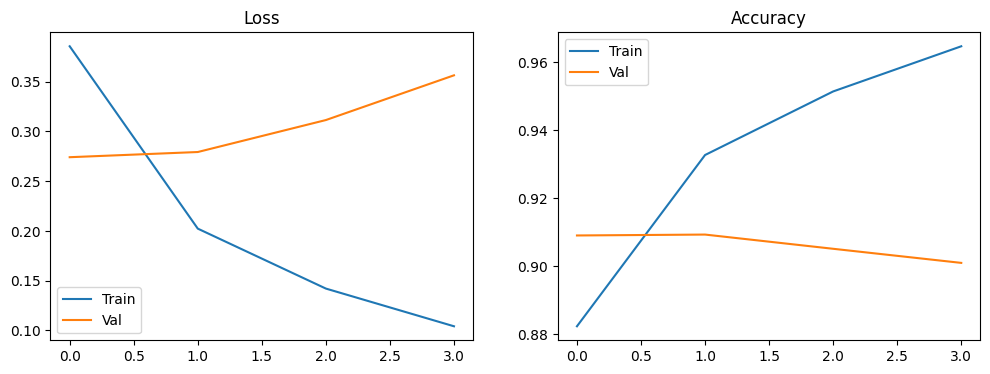

In [6]:
# Visualise loss and accuracy
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(history.history['loss'], label='Train')
    ax1.plot(history.history['val_loss'], label='Val')
    ax1.set_title('Loss')
    ax1.legend()
    
    ax2.plot(history.history['accuracy'], label='Train')
    ax2.plot(history.history['val_accuracy'], label='Val')
    ax2.set_title('Accuracy')
    ax2.legend()
    
    plt.show()
    
plot_history(history)

In [7]:
# Final evaluation metrics
X_test_dense = X_test_sparse.toarray()
y_prob = model.predict(X_test_dense)
y_pred = np.argmax(y_prob, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print(f'Neural Network Accuracy: {acc:.4f}')
print(f'Neural Network Macro-F1: {f1:.4f}')

print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Neural Network Accuracy: 0.9091
Neural Network Macro-F1: 0.9090

Classification Report:
              precision    recall  f1-score   support

       World       0.93      0.89      0.91      1900
      Sports       0.96      0.98      0.97      1900
    Business       0.88      0.86      0.87      1900
    Sci/Tech       0.87      0.91      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



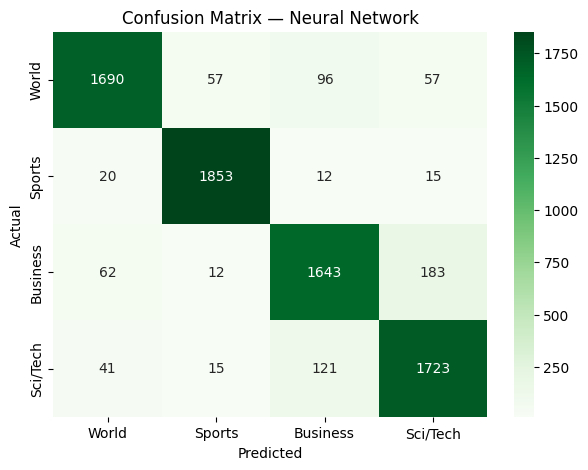

<Figure size 640x480 with 0 Axes>

In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix — Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.savefig(os.path.join(MODELS_DIR, 'nn_confusion_matrix.png'), dpi=150)

## 6 · Save Model

In [9]:
model_path = os.path.join(MODELS_DIR, 'nn_model.h5')
model.save(model_path)
print(f'✓ Neural network saved → {model_path}')

✓ Neural network saved → c:\Users\My Device\Desktop\News-Category-Classification-E\models\nn_model.h5
